In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
from datetime import datetime
from heapq import heappush,heappop

In [2]:
PATH="/home/yui/Documents/data/recommender/ratings_Beauty.csv"

#### Amazon - Ratings (Beauty Products)
2 Million data points related to Beauty products sold on Amazon.com. It contains.
- the unique UserId (Customer Identification),
- the product ASIN (Amazon's unique product identification code for each product),
- Ratings (ranging from 1-5 based on customer satisfaction) and
- the Timestamp of the rating (in UNIX time)

https://www.kaggle.com/skillsmuggler/amazon-ratings

In [3]:
func = lambda x:datetime.utcfromtimestamp(x).\
        strftime('%Y-%m-%d %H:%M:%S')
df=pd.read_csv(PATH)
df['Date']=df['Timestamp'].apply(func)
df.head(5)

,UserId,ProductId,Rating,Timestamp,Date
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200,2013-05-28 00:00:00
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200,2012-12-14 00:00:00
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200,2014-07-07 00:00:00
3,A1WMRR494NWEWV,0733001998,4.0,1382572800,2013-10-24 00:00:00
4,A3IAAVS479H7M7,0737104473,1.0,1274227200,2010-05-19 00:00:00


In [4]:
print(df.shape,df.describe())

(2023070, 5)              Rating     Timestamp
count  2.023070e+06  2.023070e+06
mean   4.149036e+00  1.360389e+09
std    1.311505e+00  4.611860e+07
min    1.000000e+00  9.087552e+08
25%    4.000000e+00  1.350259e+09
50%    5.000000e+00  1.372810e+09
75%    5.000000e+00  1.391472e+09
max    5.000000e+00  1.406074e+09


In [5]:
df['UserId'].unique().shape

(1210271,)

In [6]:
df['ProductId'].unique().shape

(249274,)

In [7]:
df['Timestamp'].unique().shape

(4231,)

#### Average Ratings
$$s = \frac{1}{N}\sum^N_{i=1}x_i$$
- Very bad estimation
- No previous records, then no ratings
- Can cause 0/0 error
- Rank by most number of ratings and highest average

In [8]:
def returnSumNProductID(df):
    d = dict()
    for row in tqdm(range(df.shape[0])):
        id_ = df.iloc[row]['ProductId']
        total,n = d.get(id_,(0,0))
        total+=df.iloc[row]['Rating']
        n+=1
        d[id_]=(total,n)
    return d
d = returnSumNProductID(df)

100%|██████████| 2023070/2023070 [04:59<00:00, 6751.53it/s]


In [15]:
def avg(d,first=10):
    h = []
    for key,val in tqdm(d.items()):
        h.append((val[0]/val[1],key,val[0],val[1]))
    h = sorted(h,key=lambda x: (-x[0],-x[3]))
    for i in range(first):
        print(h[i])
_ = avg(d,first=10)

100%|██████████| 249274/249274 [00:00<00:00, 2341730.02it/s]


(5.0, 'B004CNRDBU', 290.0, 58)
(5.0, 'B001F0RBRE', 205.0, 41)
(5.0, 'B00466VJ04', 190.0, 38)
(5.0, 'B004AI5756', 190.0, 38)
(5.0, 'B005V247N8', 185.0, 37)
(5.0, 'B0006B65PC', 155.0, 31)
(5.0, 'B002DMJM52', 150.0, 30)
(5.0, 'B00BFWD6GC', 150.0, 30)
(5.0, 'B005XRZP32', 145.0, 29)
(5.0, 'B00ANJQ8RC', 145.0, 29)


#### Average Ratings with Smoothing
$$s = \frac{1}{N+\lambda}(\lambda\mu_0+\sum^N_{i=1}x_i)$$
If $N=0$, $s=\mu_0$. We can set $\mu=3$ for an initial neutral score for each product without ratings. And $\lambda=1$ to reduce the effect of denominator to the score.

- Solve 0/0 problem but cause product with many ratings get lower average.

In [16]:
def smooth(d,first=10):
    h,lamb,init = [],1,3
    for key,val in tqdm(d.items()):
        h.append(((val[0]+lamb*init)/(val[1]+lamb),
                key,val[0],val[1]))
    h = sorted(h,key=lambda x: (-x[0],-x[3]))
    for i in range(first):
        print(h[i])
    return h
_ = smooth(d,first=10)

100%|██████████| 249274/249274 [00:00<00:00, 1589634.06it/s]


(4.966101694915254, 'B004CNRDBU', 290.0, 58)
(4.953488372093023, 'B00K7ER6LU', 423.0, 85)
(4.9523809523809526, 'B001F0RBRE', 205.0, 41)
(4.948717948717949, 'B00466VJ04', 190.0, 38)
(4.948717948717949, 'B004AI5756', 190.0, 38)
(4.947368421052632, 'B005V247N8', 185.0, 37)
(4.9375, 'B00FPROWWU', 392.0, 79)
(4.9375, 'B0006B65PC', 155.0, 31)
(4.935483870967742, 'B002DMJM52', 150.0, 30)
(4.935483870967742, 'B00BFWD6GC', 150.0, 30)


In [17]:
def roundSmooth(d,first=10):
    h,lamb,init = [],1,3
    for key,val in tqdm(d.items()):
        h.append((\
            round((val[0]+lamb*init)/(val[1]+lamb)),
                key,val[0],val[1]))
    h = sorted(h,key=lambda x: (-x[0],-x[3]))
    for i in range(first):
        print(h[i])
    return h
_ = roundSmooth(d,first=10)

100%|██████████| 249274/249274 [00:00<00:00, 688657.57it/s]


(5.0, 'B003BQ6QXK', 8872.0, 1918)
(5.0, 'B00121UVU0', 8341.0, 1838)
(5.0, 'B006IBM21K', 5412.0, 1163)
(5.0, 'B001AO0WCG', 5121.0, 1136)
(5.0, 'B003UH0528', 5184.0, 1108)
(5.0, 'B000L596FE', 4535.0, 992)
(5.0, 'B00639DLV2', 4475.0, 981)
(5.0, 'B007Q0WW0S', 4431.0, 945)
(5.0, 'B000HRVC5I', 4018.0, 885)
(5.0, 'B000OYJ9AO', 3908.0, 865)


#### Wilson Lower bound Score
Rather than ranking with number of ratings $N$, another way is confidence interval which can take $N$ into account as well. The less the $N$ is, the less confident the score is, the score should be thus downgraded. The lower bound of confidence interval can reflect this, since the less certain we are, the more the lower bound is towards 0.

**Bernoulli Confidence Interval Approximation**

- Possible outcomes: 0/1
- Lower Bound:
$$\hat{p}-1.96\sqrt{\frac{\hat{p}(1-\hat{p})}{N}}$$
where $\hat{p}=\frac{1}{N}\sum_i \mathbb{I}(x_i=1)$
- Wilson Lower Bound:
$$\frac{\hat{p}+\frac{z^2}{2N}}{1+\frac{z^2}{N}}-\frac{z}{1+\frac{z^2}{N}}\sqrt{\frac{\hat{p}(1-\hat{p})}{N}+\frac{z^2}{4N^2}}$$
where $z=\Phi^{-1}(0.25)$ and $\Phi$ cdf.

**K star scale**

- Wilson Lower Bound:
$$
\sum^K_{k=1}s_k\frac{n_k+1}{N+K}-z_{\alpha/2}\sqrt{\frac{1}{N+K+1}\bigg(\sum^K_{k=1}s_k^2\frac{n_k+1}{N+K}-\big(\sum^K_{k=1}\frac{n_k+1}{N+K}\big)^2\bigg)}
$$
where $K$ is the maximum of stars, $N$ the number of ratings, $n_k$ number of k stars, $s_k$ star scale.

Text(0, 0.5, 'p(x)')

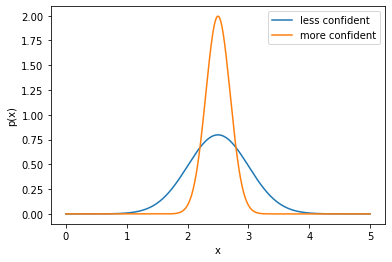

In [20]:
from scipy.stats import norm
x = np.linspace(0,5,1000)
y0 = norm.pdf(x,2.5,0.5)
y1 = norm.pdf(x,2.5,0.2)
plt.plot(x,y0,label='less confident')
plt.plot(x,y1,label='more confident')
plt.legend()
plt.xlabel('x')
plt.ylabel('p(x)')